# Lesson 1 - What's your image

Project 1: discriminate between images with sketches, paintings and pictures:

The image classifier is built from scratch, and see if we can achieve world-class results. Let's dive in!

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [3]:
from fastai import *
from fastai.vision import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [8]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

In [5]:
path = Path('/fastai/data/imagetypes')

In [6]:
path.ls()

[PosixPath('/fastai/data/imagetypes/sketch'),
 PosixPath('/fastai/data/imagetypes/painting'),
 PosixPath('/fastai/data/imagetypes/models'),
 PosixPath('/fastai/data/imagetypes/picture')]

In [7]:
classes = ['sketch','painting','picture']

Data is organized into a dataset following the instructions on https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb

In [13]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

sketch


Image /fastai/data/imagetypes/sketch/sketch.png has 1 instead of 3
Image /fastai/data/imagetypes/sketch/stella%20sketch%20resized.jpg has 1 instead of 3
Image /fastai/data/imagetypes/sketch/picture21427881845.jpg has 1 instead of 3
Image /fastai/data/imagetypes/sketch/ban1448605179.jpg has 1 instead of 3
Image /fastai/data/imagetypes/sketch/pencil-sketches-500x500.jpg has 1 instead of 3
Image /fastai/data/imagetypes/sketch/324+-+heart+sketch+t-shirt+-+anatomical+human+heart+-+funny+tee.jpg has 1 instead of 3
cannot identify image file <_io.BufferedReader name='/fastai/data/imagetypes/sketch/sketch-woman-pointing.svg'>
cannot identify image file <_io.BufferedReader name='/fastai/data/imagetypes/sketch/dancing-sketch.svg'>
Image /fastai/data/imagetypes/sketch/john-doe-sketch.jpg has 1 instead of 3
Image /fastai/data/imagetypes/sketch/santa-ana-perv.jpeg has 1 instead of 3
Image /fastai/data/imagetypes/sketch/09-retouched.jpg has 1 instead of 3
Image /fastai/data/imagetypes/sketch/2136-18

Image /fastai/data/imagetypes/painting/coffee-painting-birds.png has 1 instead of 3
Image /fastai/data/imagetypes/painting/canvas-oil-painting-250x250.png has 4 instead of 3
image file is truncated (21 bytes not processed)
picture


image file is truncated (48 bytes not processed)
Image /fastai/data/imagetypes/picture/arbre.png has 4 instead of 3
Image /fastai/data/imagetypes/picture/img-people-harsha-s-abeykoon.png has 1 instead of 3


In [11]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

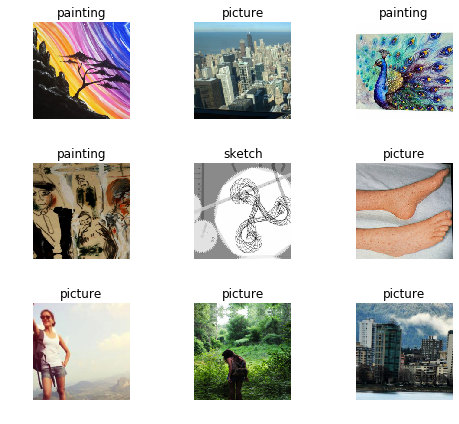

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [16]:
print(data.classes)
len(data.classes),data.c

['sketch', 'painting', 'picture']


(3, 3)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories.

We will train for 4 epochs (4 cycles through all our data).

In [17]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:16<00:00, 5390854.00it/s] 


In [20]:
learn.fit_one_cycle(4)

Total time: 00:29
epoch  train_loss  valid_loss  error_rate
1      0.081165    0.218525    0.054608    (00:07)
2      0.077608    0.264936    0.075085    (00:07)
3      0.094276    0.244796    0.054607    (00:06)
4      0.076838    0.247646    0.061433    (00:07)



In [21]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

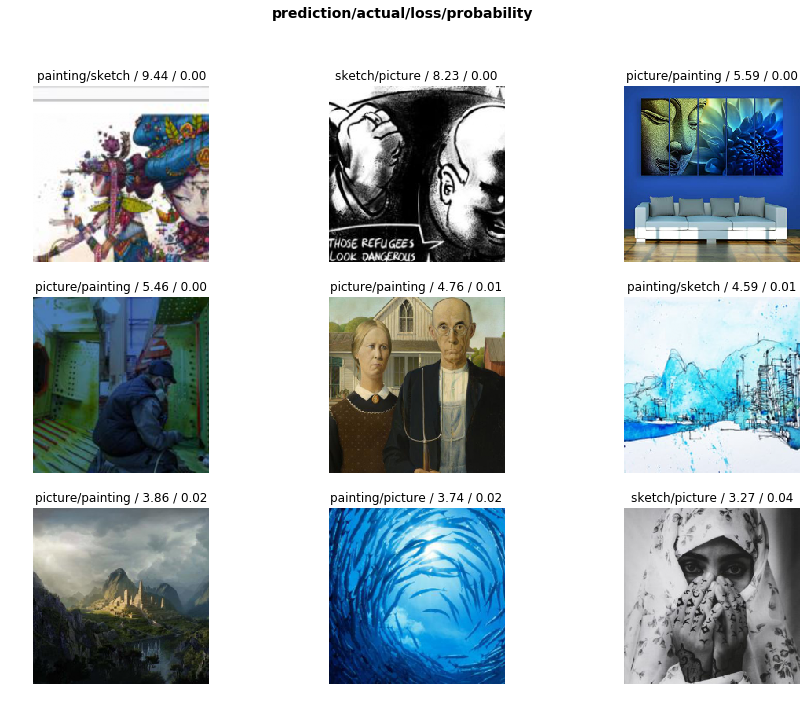

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

As we can see, most of the confussions happen because of incorrectly labelled data (labeled as sketch when its a painting/picture, or two-way viceversa), or when one of the images looks a lot like of other category, like a very realistic painting categorized as pictre.

In [24]:
doc(interp.plot_top_losses)

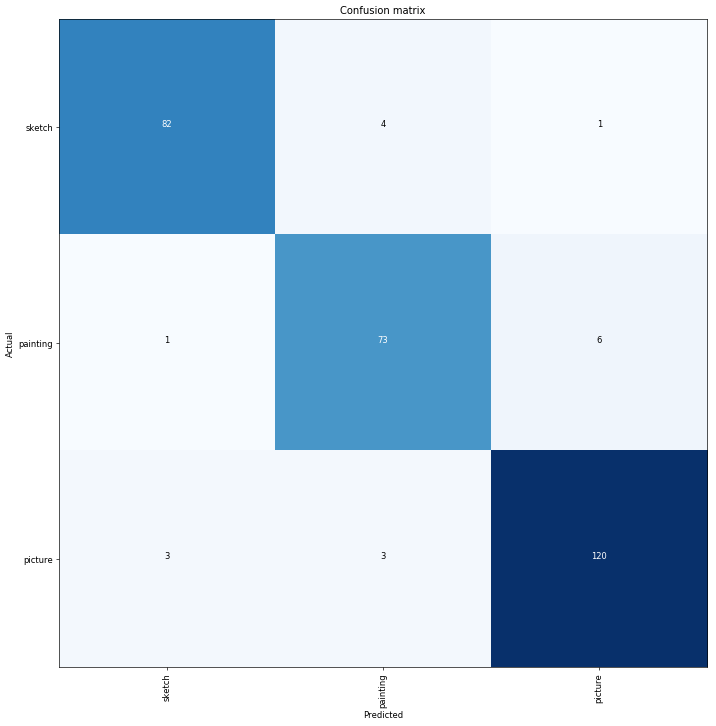

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [26]:
interp.most_confused(min_val=2)

[('painting', 'picture', 6),
 ('sketch', 'painting', 4),
 ('picture', 'sketch', 3),
 ('picture', 'painting', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [27]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


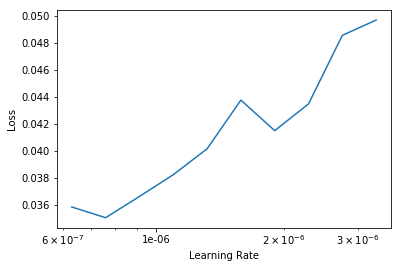

In [33]:
learn.recorder.plot()

In [34]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 00:15
epoch  train_loss  valid_loss  error_rate
1      0.044788    0.255539    0.061433    (00:07)
2      0.042473    0.254998    0.058020    (00:07)



In [ ]:
learn.save('stage-1')

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [36]:
# data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=299, bs=bs//2).normalize(imagenet_stats)
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, bs=bs//2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [37]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [02:51<00:00, 597309.31it/s] 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


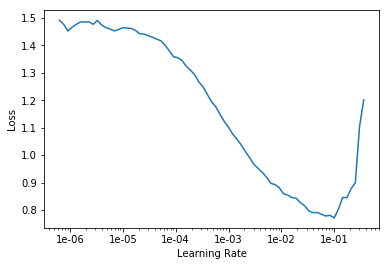

In [38]:
learn.lr_find()
learn.recorder.plot()

In [40]:
lr = 1e-03/2
learn.fit_one_cycle(6, slice(lr))

Total time: 00:44
epoch  train_loss  valid_loss  error_rate
1      0.091969    0.249853    0.075085    (00:07)
2      0.088116    0.267597    0.064846    (00:07)
3      0.093269    0.270988    0.068259    (00:07)
4      0.099859    0.252977    0.078498    (00:07)
5      0.080275    0.254708    0.075085    (00:07)
6      0.068750    0.256875    0.078498    (00:07)



In [41]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


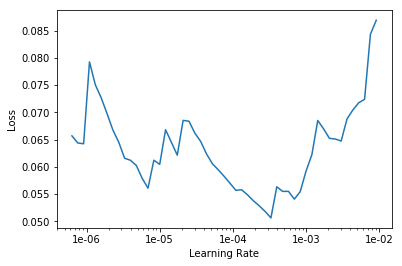

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,2e-4))

Total time: 00:28
epoch  train_loss  valid_loss  error_rate
1      0.068620    0.262655    0.071672    (00:10)
2      0.066665    0.244398    0.068259    (00:09)
3      0.052882    0.248114    0.071672    (00:09)



If it doesn't, you can always go back to your previous model.

In [88]:
learn.save('stage-2-50');

In [44]:
interp = ClassificationInterpretation.from_learner(learn)

In [45]:
interp.most_confused(min_val=2)

[('painting', 'picture', 8),
 ('sketch', 'painting', 4),
 ('picture', 'painting', 4),
 ('picture', 'sketch', 3)]

# Predict class:

Create a netowrk for inference and load the latest trained model:

In [8]:
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [9]:
learn = create_cnn(data2, models.resnet50).load('stage-2-50')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 20715206.15it/s]


Select a class at random and a picture of that class at random:

In [46]:
test_class = classes[random.randint(0, data.c-1)]
test_names = get_image_files(path/test_class)
test_class

'picture'

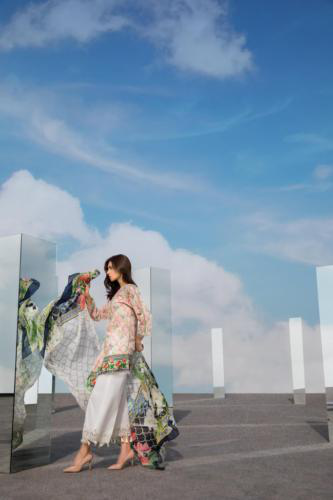

In [47]:
n_img = len(test_names)
img_f = test_names[random.randint(0, n_img-1)]
img = open_image(img_f)
img

Classify the image:

In [48]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'picture'

Or all at once:

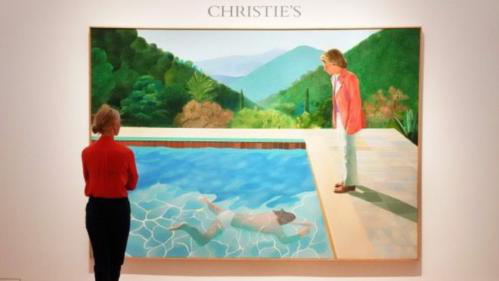

In [63]:
test_class = classes[random.randint(0, data.c-1)]
test_names = get_image_files(path/test_class)
n_img = len(test_names)
img_f = test_names[random.randint(0, n_img-1)]
img = open_image(img_f)
pred_class,pred_idx,outputs = learn.predict(img)
img

In [64]:
pred_class

'painting'